In [ ]:
# 고급 회귀 기법

In [ ]:
자전거 대여 수요 예측: https://www.kaggle.com/competitions/bike-sharing-demand/data
주택 가격: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

### 데이터 사전 처리(Preprocessing)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 데이터 불러오기
house_df_org  = pd.read_csv(f'data/house_price_train.csv', encoding='cp949')  #TODO:YOUR_CODE_HERE
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
house_df.shape

(1460, 81)

In [5]:
print('### Feature type ###')
print(house_df.iloc[:,:-1].dtypes.value_counts())

print('\n### Null Feature ###')
isnull_series = house_df.isnull().sum() # Null 데이터의 갯수 확인하기 #TODO:YOUR_CODE_HERE
print(isnull_series[isnull_series > 0].sort_values(ascending=False))

### Feature type ###
object     43
int64      34
float64     3
Name: count, dtype: int64

### Null Feature ###
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


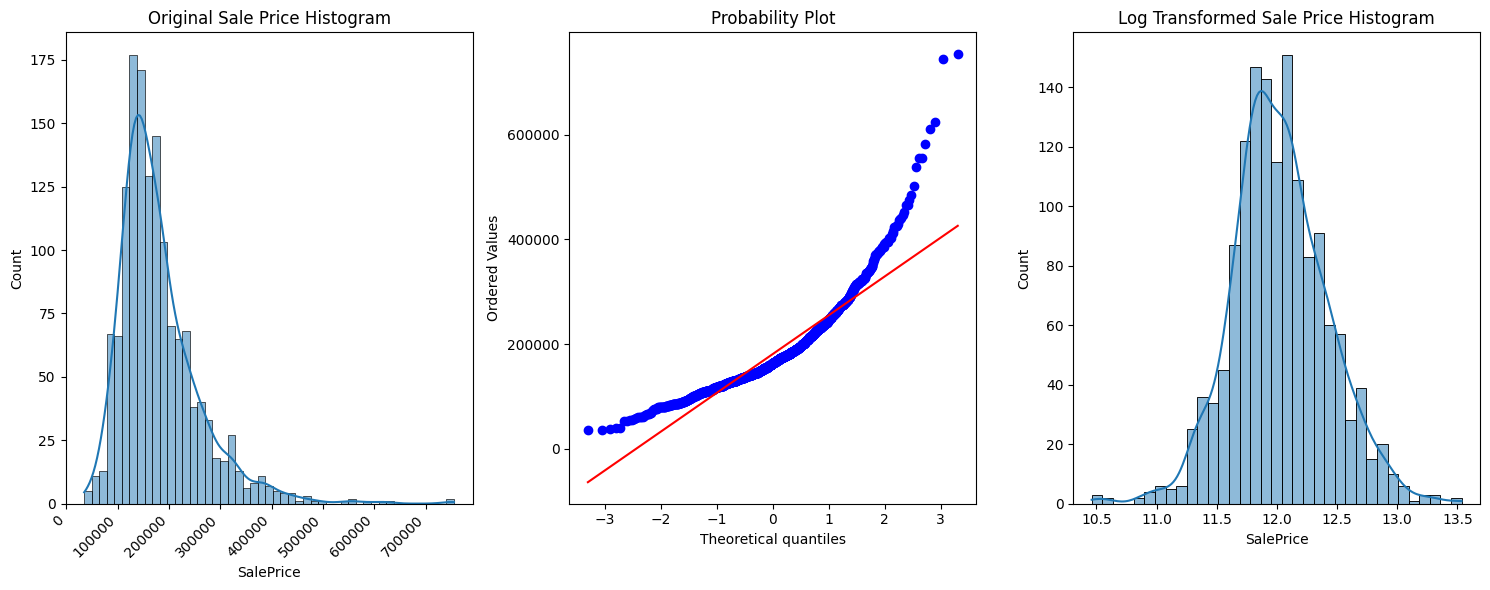

In [6]:
# 시각화를 통해 SalePrice의 분포도 확인

from scipy import stats

fig, axs = plt.subplots(1,3, figsize = (15,6))

sns.histplot(house_df["SalePrice"], ax =axs[0], kde=True)
stats.probplot(house_df["SalePrice"], dist='norm', fit=True, plot=axs[1])
sns.histplot(np.log1p(house_df["SalePrice"]), ax=axs[2], kde=True)

axs[0].set_title("Original Sale Price Histogram")
axs[2].set_title("Log Transformed Sale Price Histogram")

for label in axs[0].get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

plt.tight_layout()
plt.show()

In [7]:
# # 피처 제거
# # Null 데이터가 1000개 이상인 피처 제거
house_df.drop(["Id", "PoolQC", "MiscFeature", "Alley", "Fence"], axis=1, inplace=True)

# 종속 변수 로그 변환
org_SalePrice = house_df["SalePrice"]
house_df["SalePrice"] = np.log1p(house_df["SalePrice"])

# 결측값 대체 - 숫자형
numeric_cols = house_df.select_dtypes(include=[np.number]).columns
house_df[numeric_cols] = house_df[numeric_cols].fillna(house_df[numeric_cols].mean())

# 원-핫 인코딩 - 카테고리형
house_df_ohe = pd.get_dummies(house_df) # TODO: YOUR_CODE_HERE

# 결과 확인
print(house_df_ohe.head())

   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0          2003       196.0         706           0  ...           False   
1          1976         0.0         978           0  ...           False   
2          2002       162.0         486           0  ...           False   
3          1970         0.0         216           0  ...           False   
4          2000       350.0         655           0  ...           False   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0         False  

In [10]:
print('### Feature type ###')
print(house_df.iloc[:,:-1].dtypes.value_counts())

print('\n### Null Feature ###')
isnull_series = house_df.isnull().sum() # Null 데이터의 갯수 확인하기 #TODO:YOUR_CODE_HERE
print(isnull_series[isnull_series > 0].sort_values(ascending=False))

### Feature type ###
object     39
int64      33
float64     3
Name: count, dtype: int64

### Null Feature ###
MasVnrType      872
FireplaceQu     690
GarageQual       81
GarageFinish     81
GarageCond       81
GarageType       81
BsmtExposure     38
BsmtFinType2     38
BsmtCond         37
BsmtQual         37
BsmtFinType1     37
Electrical        1
dtype: int64


In [9]:
print("원-핫 인코딩 전 shape:", house_df.shape)
print("원-핫 인코딩 후 shape:", house_df_ohe.shape)

원-핫 인코딩 전 shape: (1460, 76)
원-핫 인코딩 후 shape: (1460, 275)


### 선형 회귀 모델의 학습/예측/평가

#### 기본 예측/평가

##### RMSE함수

In [11]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print(f'{model.__class__.__name__} 로그 변환된 RMSE: {np.round(rmse, 4)}')

    return rmse

def get_rmses(models):
    rmses = []

    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)

    return rmses

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
y_target = house_df_ohe['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 모델 적용하기
lr_reg = LinearRegression()        # TODO: YOUR_CODE_HERE
ridge_reg = Ridge()     # TODO: YOUR_CODE_HERE
lasso_reg = Lasso()    # TODO: YOUR_CODE_HERE

lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# 예측 평가
models = [lr_reg, ridge_reg, lasso_reg]
rmses = get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.1321
Ridge 로그 변환된 RMSE: 0.1281
Lasso 로그 변환된 RMSE: 0.1763


##### 회귀 계수 시각화 함수

In [13]:
# 상위, 하위 10개 coefficients 추출
def get_top_bottom_coef(model):
    # coef series
    coef = pd.Series(model.coef_, index = X_features.columns)

    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

# 회귀 계수 시각화
def visualize_coefficient(models, xlim=None):
    fig, axs = plt.subplots(3,1, figsize=(24,20))
    fig.tight_layout()

    for i, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low], axis=0 )

        axs[i].set_title(model.__class__.__name__ , size=25, x= 0.9, y= 0.1)

        # font size 조정
        for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
            label.set_fontsize(22)

        # x축 범위
        if xlim:
            axs[i].set_xlim(xlim)

        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i])

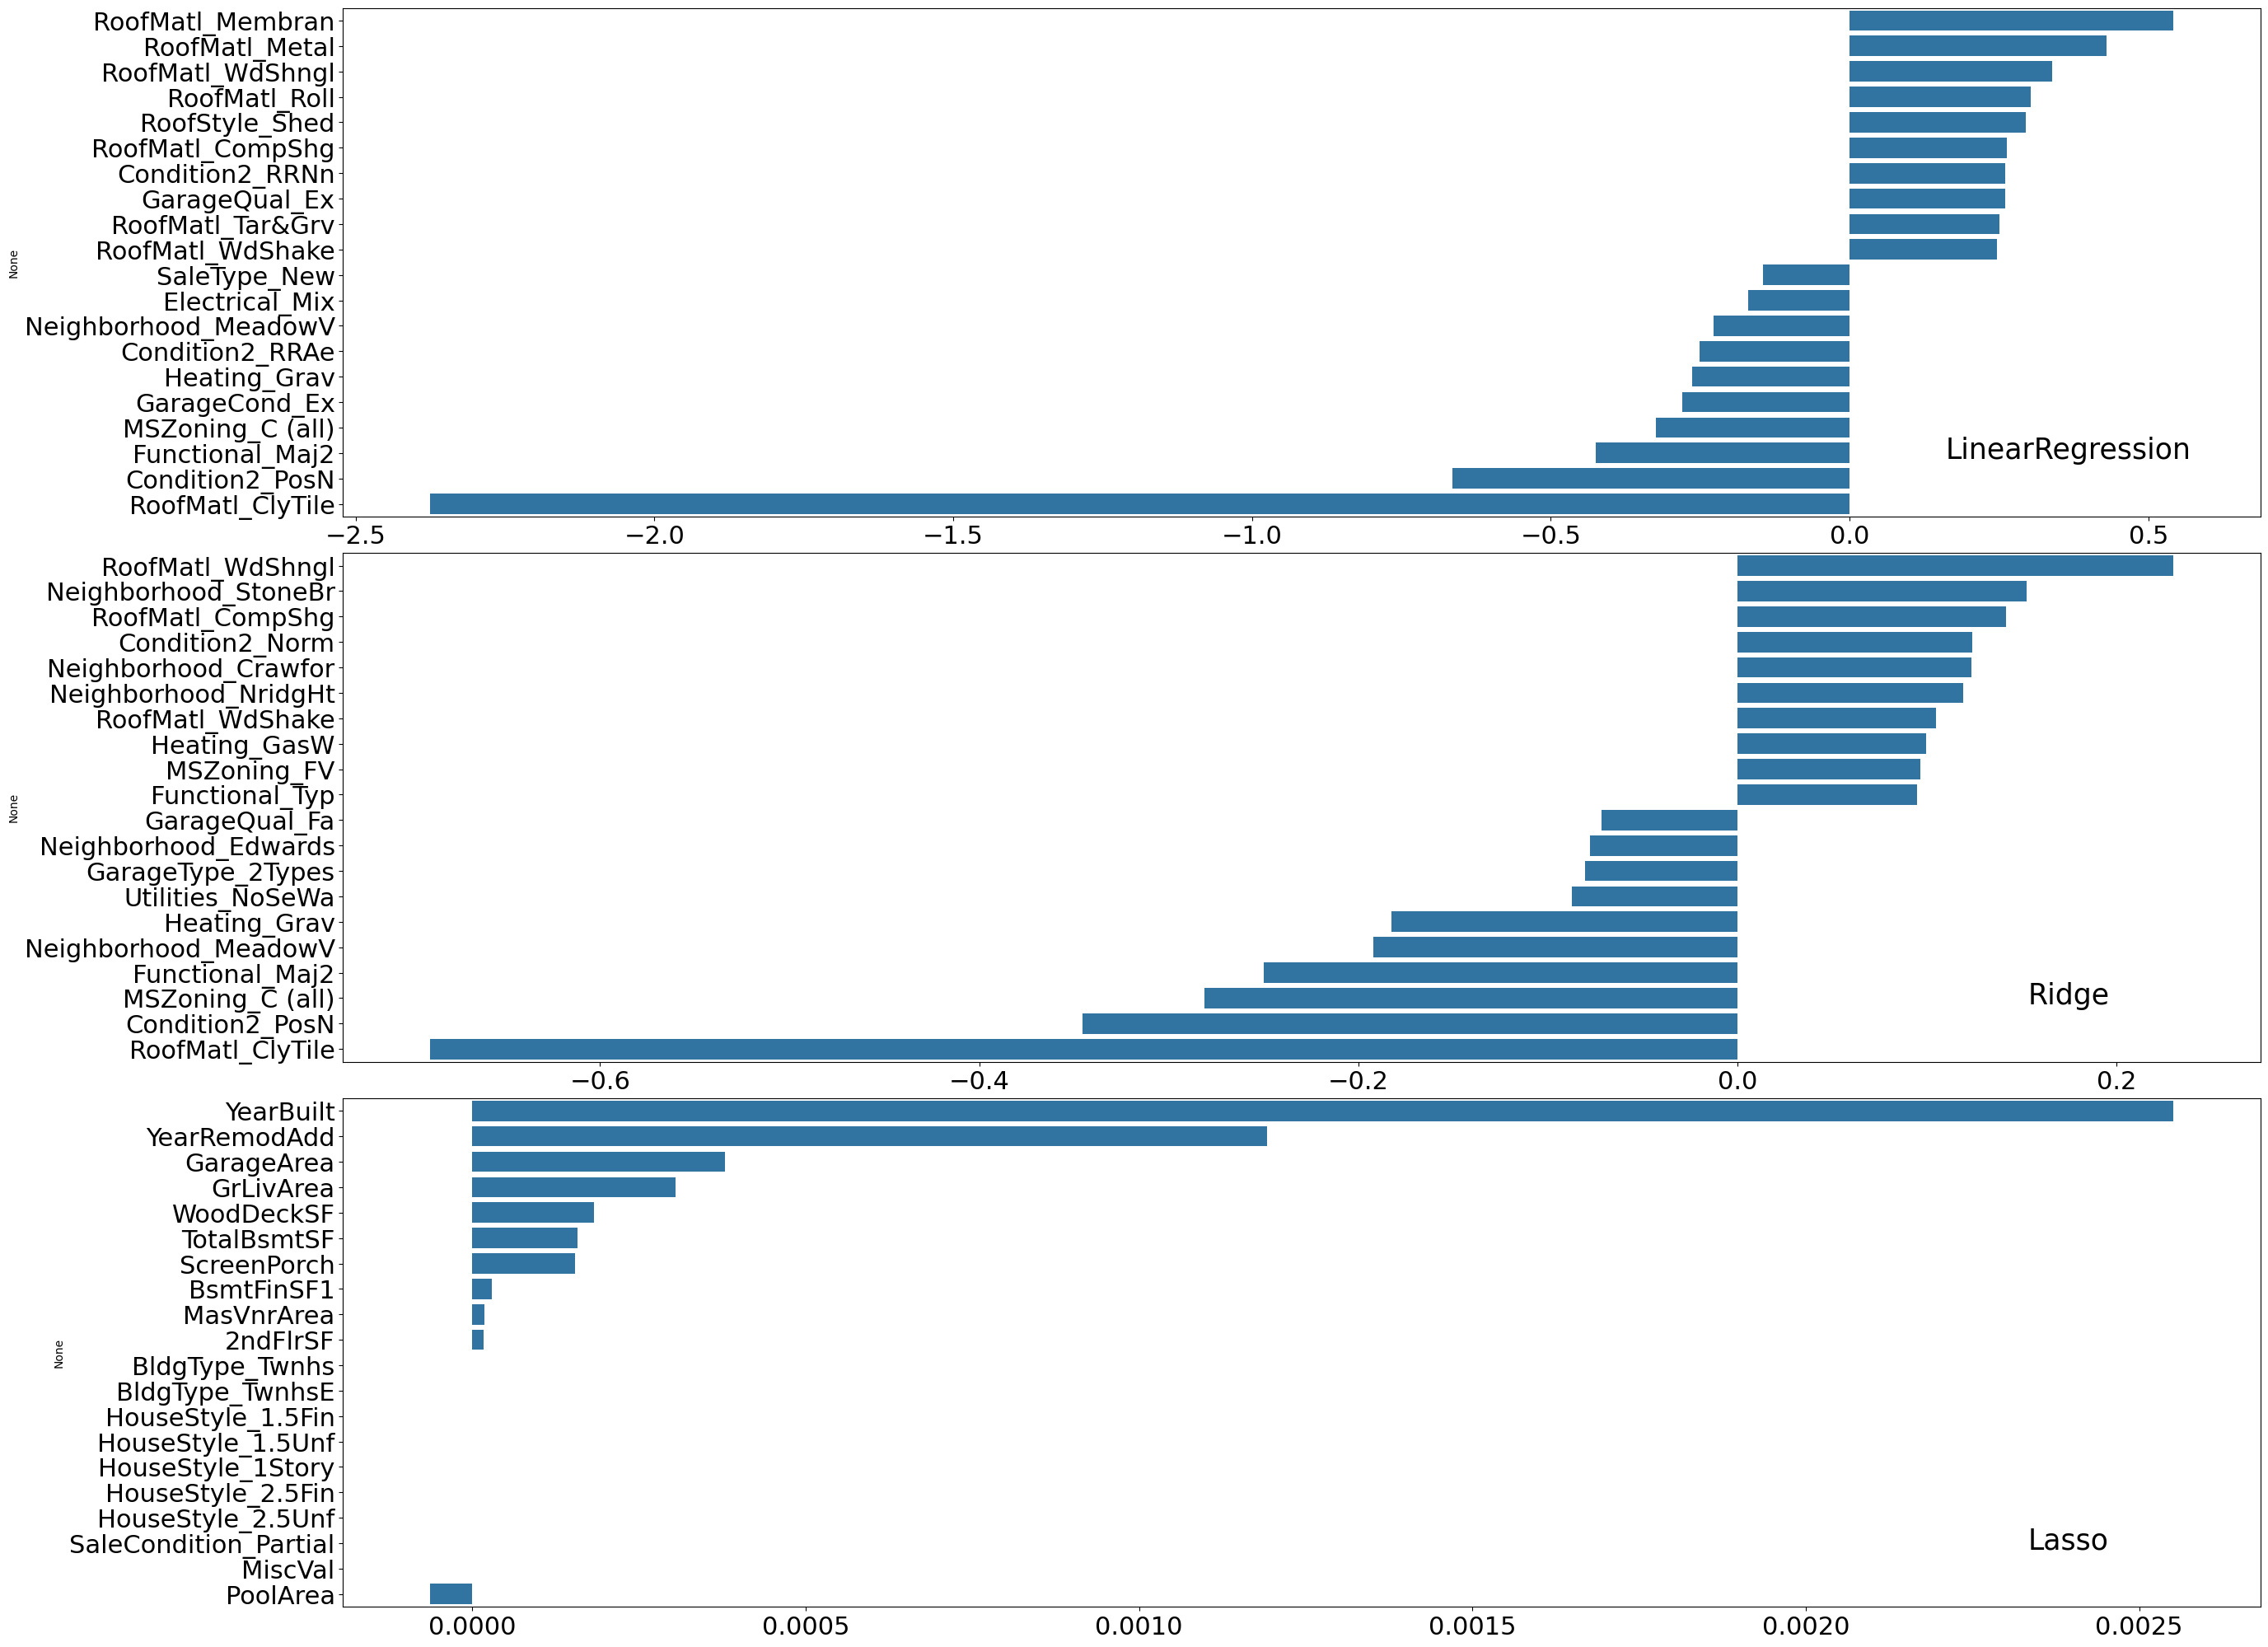

In [ ]:
# LinearRegression, Ridge, Lasso
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

#### 교차검증

##### 교차검증 평균 RMSE 함수

In [14]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

    for model in models:
        mse_scores = -1*cross_val_score(model, X_features, y_target,
                                        scoring="neg_mean_squared_error", cv=5)
        rmse_scores = np.sqrt(mse_scores)
        rmse_avg = np.mean(rmse_scores)

        print(f"{model.__class__.__name__} CV RMSE 리스트: {np.round(rmse_scores,3)}")
        print(f"{model.__class__.__name__} CV 평균 RMSE: {rmse_avg:.3f}\n")

In [15]:
# LinearRegression, Ridge, Lasso
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)

LinearRegression CV RMSE 리스트: [0.136 0.166 0.167 0.111 0.197]
LinearRegression CV 평균 RMSE: 0.155

Ridge CV RMSE 리스트: [0.118 0.156 0.142 0.117 0.188]
Ridge CV 평균 RMSE: 0.144

Lasso CV RMSE 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE: 0.198



#### GridSearchCV

##### 하이퍼 파라미터 도출 함수

In [16]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    model_name = model.__class__.__name__
    grid_cv = GridSearchCV(model, param_grid=params,
                           scoring='neg_mean_squared_error', cv=5)

    grid_cv.fit(X_features, y_target)
    best_rmse = np.sqrt(-1* grid_cv.best_score_)

    print(f'{model_name} GridSearchCV 최적 평균 RMSE: {np.round(best_rmse, 4)}, 최적 alpha:{grid_cv.best_params_}')

    return grid_cv.best_estimator_

In [17]:
# 하이퍼 파라미터
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

# Ridge, Lasso
ridge_reg = Ridge()
lasso_reg = Lasso()

best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge GridSearchCV 최적 평균 RMSE: 0.1418, 최적 alpha:{'alpha': 12}
Lasso GridSearchCV 최적 평균 RMSE: 0.142, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.1321
Ridge 로그 변환된 RMSE: 0.1246
Lasso 로그 변환된 RMSE: 0.1204


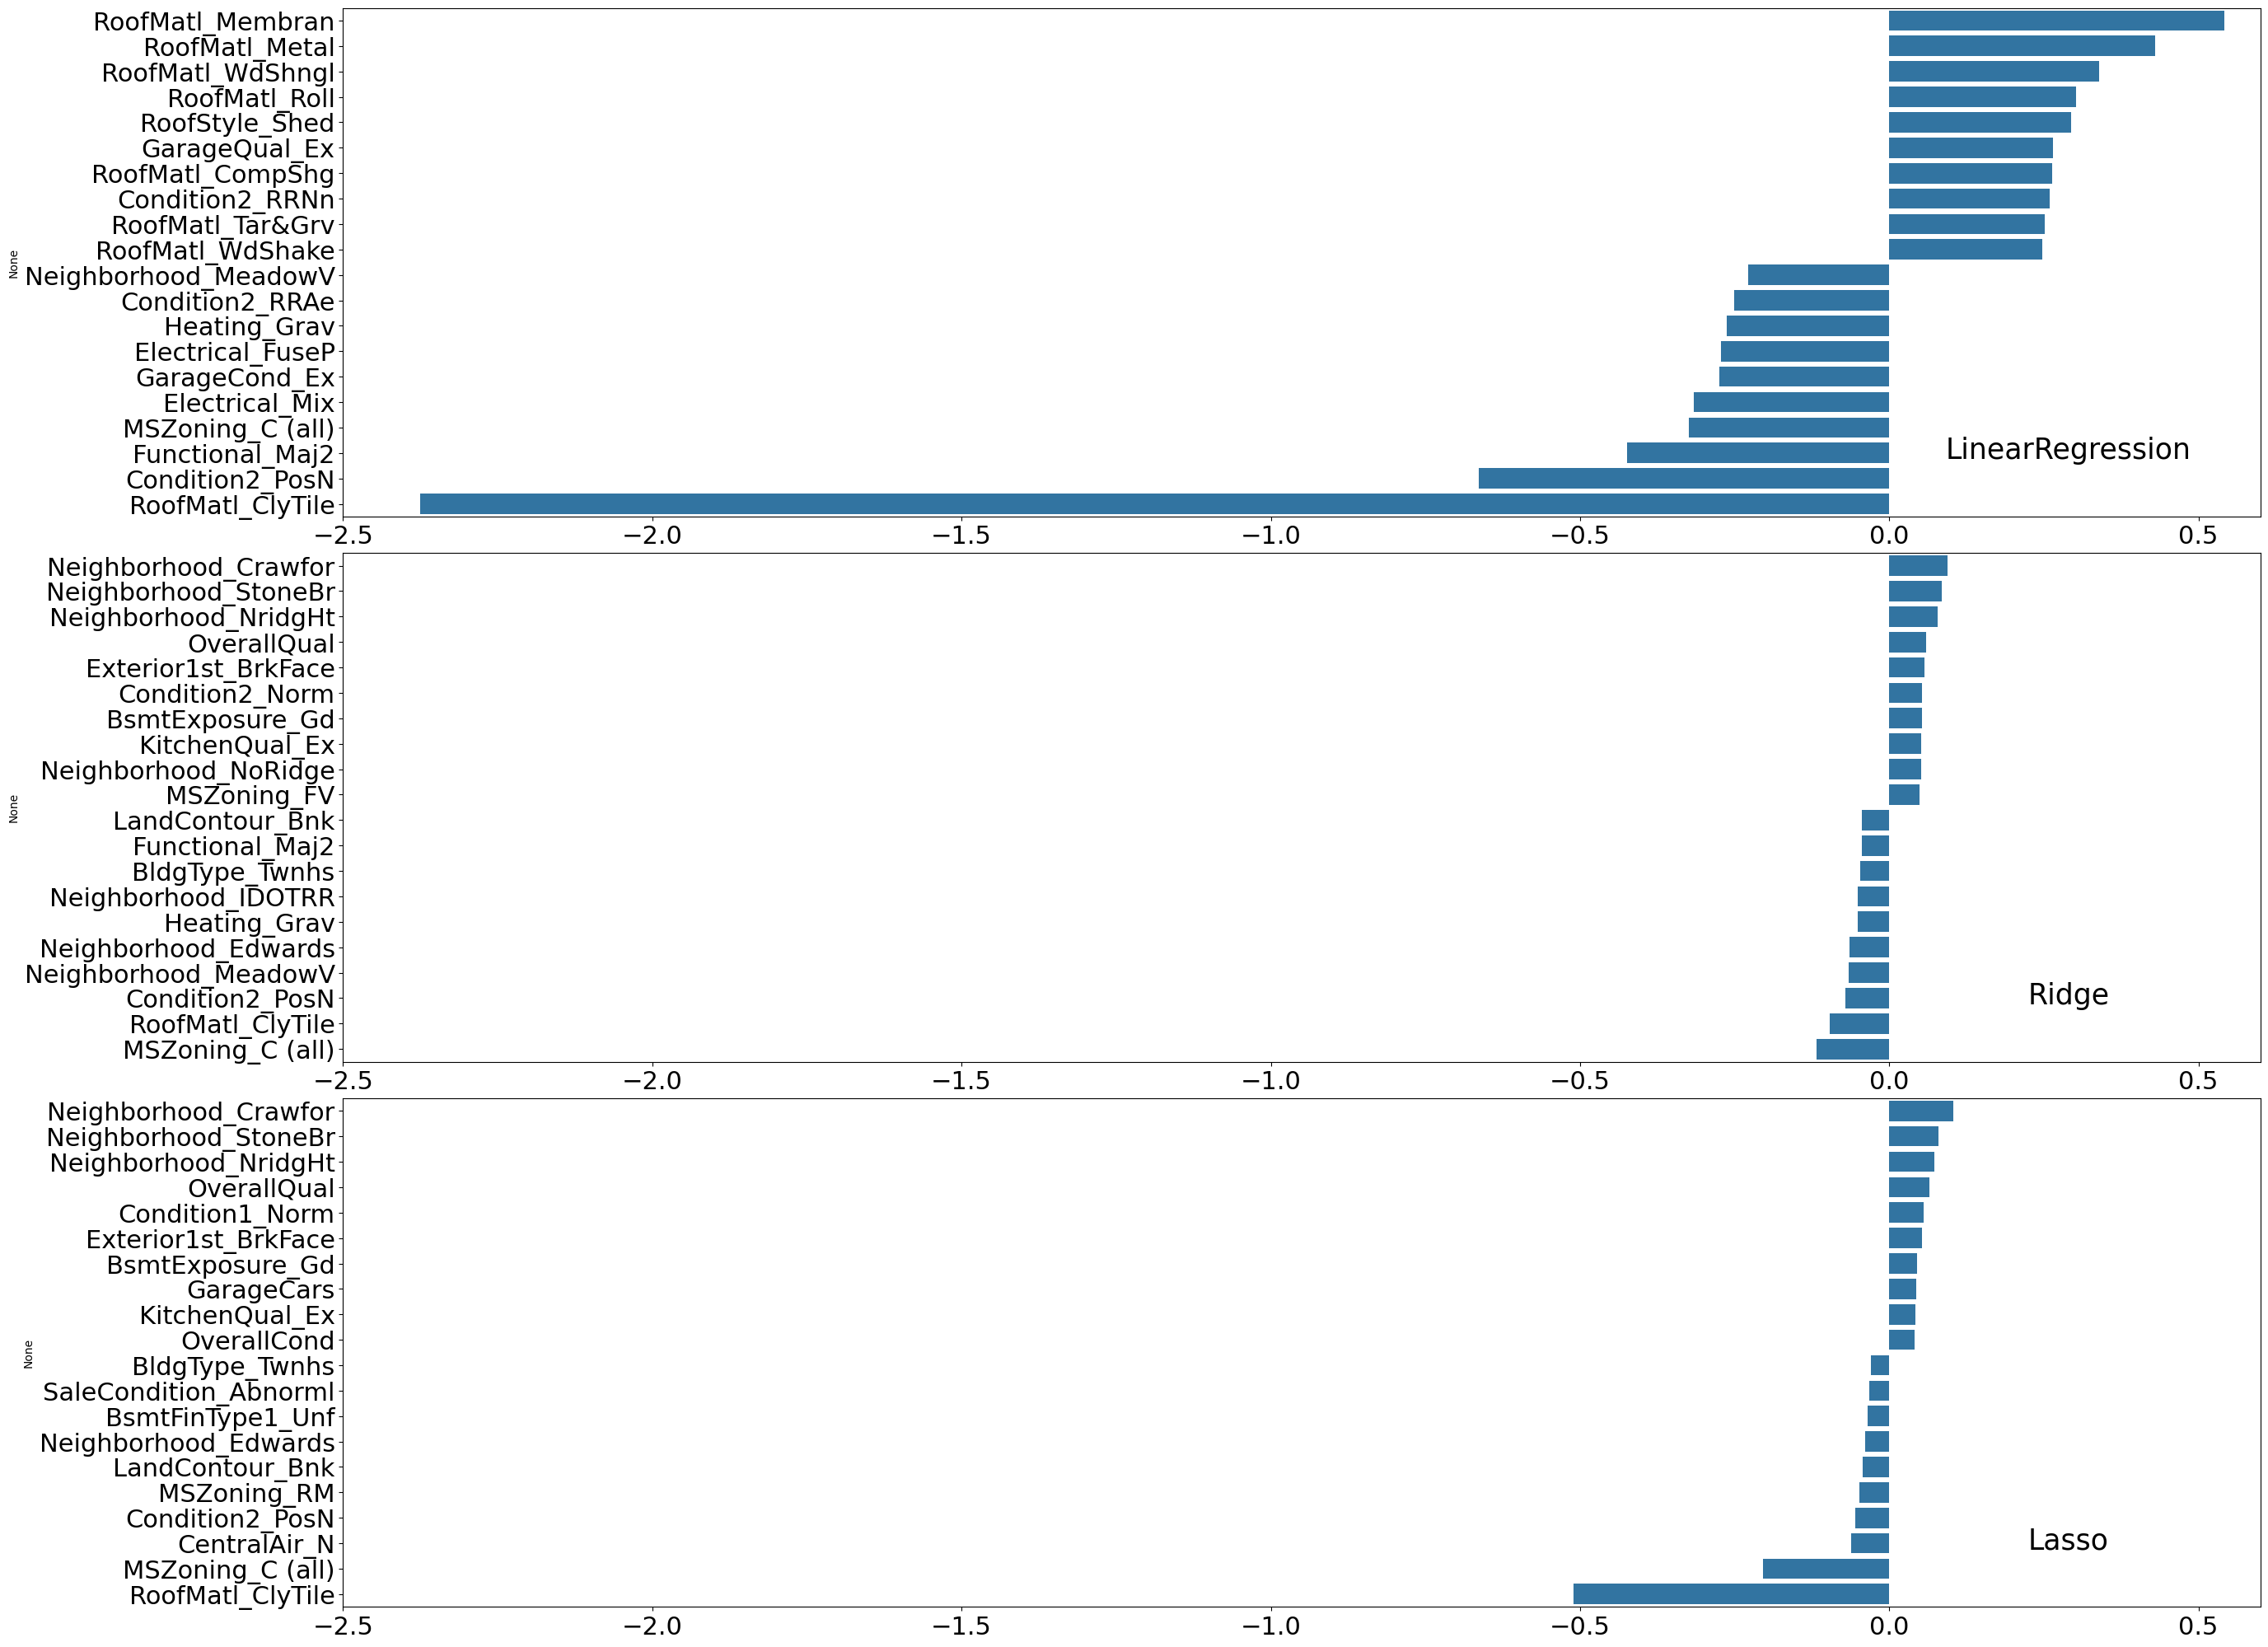

In [18]:
# 최적 하이퍼 파라미터로 Ridge, Lasso 수정
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=12)
lasso_reg = Lasso(alpha=0.001)

lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# test set RMSE
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models, xlim=(-2.5,0.6))

#### 피처 로그 변환
데이터 왜곡 로그 변환 후 성능 평가

In [19]:
from scipy.stats import skew

# 숫자형 피처 컬럼 index
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# 피처(열)별로 왜곡도 산출
skew_features = house_df[features_index].apply(lambda x : skew(x), axis=0)

# 왜곡도가 1 이상
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [22]:
# 피처 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

# 원-핫 인코딩
house_df_ohe2 = pd.get_dummies(house_df)

# 데이터 재분리
X_features = house_df_ohe2.drop('SalePrice',axis=1, inplace=False)
y_target = house_df_ohe2['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [23]:
# 하이퍼 파라미터
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

# Ridge, Lasso
ridge_reg = Ridge()
lasso_reg = Lasso()

best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge GridSearchCV 최적 평균 RMSE: 0.1379, 최적 alpha:{'alpha': 1}
Lasso GridSearchCV 최적 평균 RMSE: 0.1386, 최적 alpha:{'alpha': 0.001}


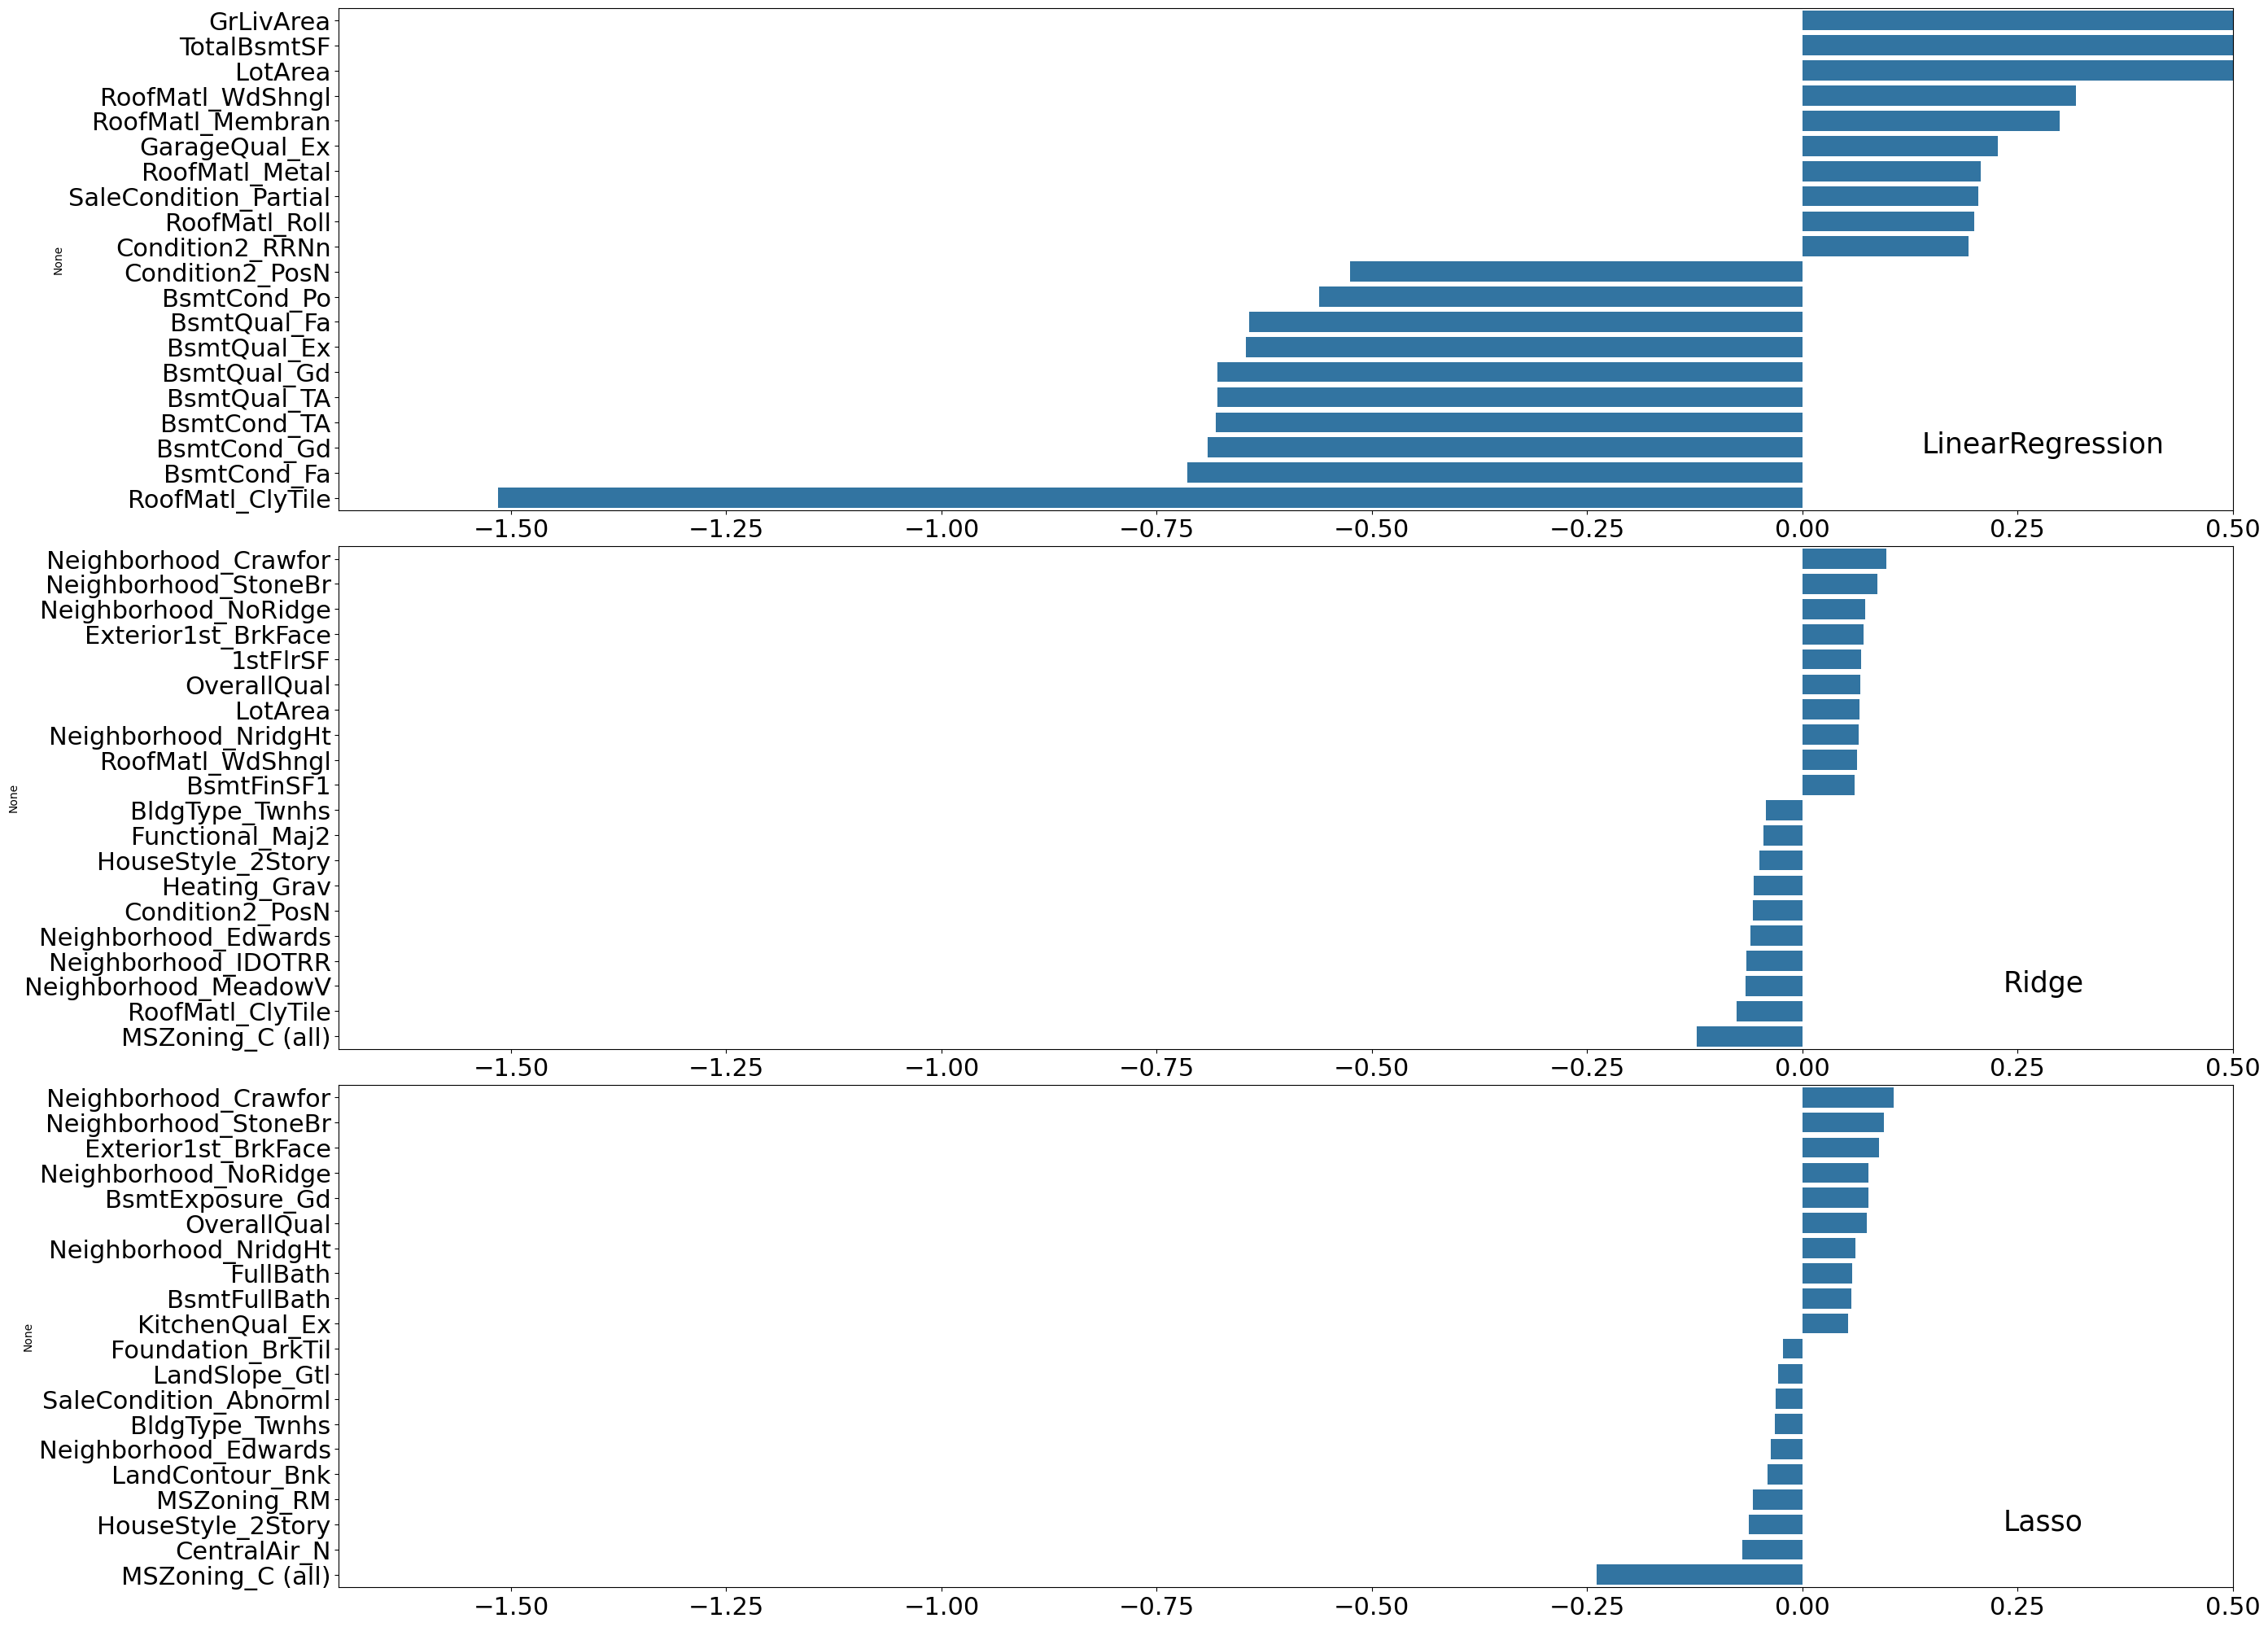

In [25]:
# 최적 하이퍼 파라미터로 Ridge, Lasso 수정
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha = 12)
lasso_reg = Lasso(alpha = 0.001)

lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models, xlim=(-1.7,0.5))

#### 이상치 제거

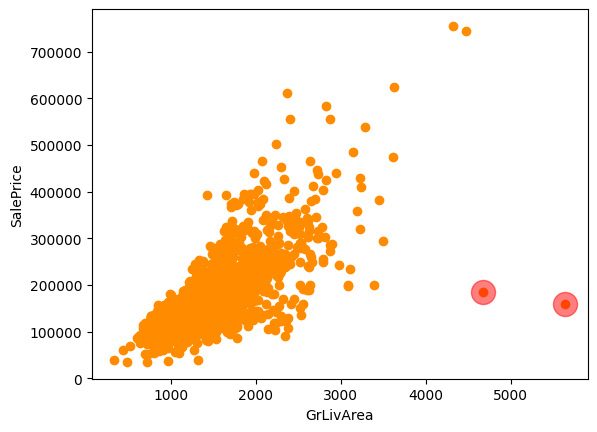

In [26]:
plt.scatter(house_df_org["GrLivArea"] , house_df_org["SalePrice"], c="darkorange")
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')

# 추후 확인한 이상치 표시
idx = (house_df_org["GrLivArea"] > 4000) & (house_df_org["SalePrice"] < 200000)
outlier_df = house_df_org[idx]
plt.scatter(outlier_df["GrLivArea"] , outlier_df["SalePrice"], s=300, c="r", alpha=0.5 )

plt.show()

In [27]:
# GrLivArea, SalePrice 모두 로그 변환 하였으므로 반영한 조건 생성
cond1 = house_df_ohe2['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe2['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe2[cond1 & cond2].index

house_df_ohe3 = house_df_ohe2.drop(outlier_index , axis=0, inplace=False)

print('이상치 삭제 전 house_df_ohe2 shape:', house_df_ohe2.shape)
print('이상치 삭제 후 house_df_ohe3 shape:', house_df_ohe3.shape)

이상치 삭제 전 house_df_ohe2 shape: (1460, 275)
이상치 삭제 후 house_df_ohe3 shape: (1460, 275)


In [28]:
# 데이터 재분리
X_features = house_df_ohe3.drop('SalePrice',axis=1, inplace=False)
y_target = house_df_ohe3['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [29]:
# 하이퍼 파라미터
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

# Ridge, Lasso
ridge_reg = Ridge()
lasso_reg = Lasso()

best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge GridSearchCV 최적 평균 RMSE: 0.1379, 최적 alpha:{'alpha': 1}
Lasso GridSearchCV 최적 평균 RMSE: 0.1386, 최적 alpha:{'alpha': 0.001}


In [30]:
# 최적 하이퍼 파라미터로 Ridge, Lasso 수정
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha = 8)
lasso_reg = Lasso(alpha = 0.001)

lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# test set RMSE
models = [lr_reg, ridge_reg, lasso_reg]
rmses = get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.1292
Ridge 로그 변환된 RMSE: 0.1362
Lasso 로그 변환된 RMSE: 0.1326


### 회귀 트리 학습/예측/평가

In [31]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)

best_xgb = get_best_params(xgb_reg, xgb_params)

XGBRegressor GridSearchCV 최적 평균 RMSE: 0.1261, 최적 alpha:{'n_estimators': 1000}


In [32]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

best_lgbm = get_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3167
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 176
[LightGBM] [Info] Start training from score 12.021409
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3178
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 172
[LightGBM] [Info] Start training from score 12.023288
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

### 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

##### 혼합 RMSE함수

In [33]:
def get_rmse_pred(preds):
    for key in preds.keys():
        prediction = preds[key]

        mse = mean_squared_error(y_test, prediction)
        rmse = np.sqrt(mse)

        print(f"{key} 모델 RMSE: {rmse:.4f}")

In [34]:
ridge_reg = Ridge(alpha=8)
lasso_reg = Lasso(alpha=0.001)

ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 혼합 예측
fusion_pred = 0.4*ridge_pred + 0.6*lasso_pred

# 개별 예측, 혼합 예측 평가
preds = {
    "Ridge": ridge_pred,
    "Lasso": lasso_pred,
    "Fusion": fusion_pred
}

get_rmse_pred(preds)

Ridge 모델 RMSE: 0.1362
Lasso 모델 RMSE: 0.1326
Fusion 모델 RMSE: 0.1324


### 스태킹 앙상블 회귀

##### CV 스태킹 함수

In [35]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd

# 데이터 프레임, 시리즈 -> Numpy 배열 변환
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

# 개별 모델별 메타 데이터 생성 함수
def get_stacking_base_datasets(model, X_train, y_train, X_test, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)

    train_cnt = X_train.shape[0]
    test_cnt = X_test.shape[0]
    train_meta = np.zeros((train_cnt, 1))
    test_meta = np.zeros((test_cnt, n_folds))

    print(f'{model.__class__.__name__} model 시작')

    for i, (train_fold_idx, test_fold_idx) in enumerate(kf.split(X_train)):
        print(f'\t폴드 세트: {i+1} 시작')
        x_train_fold = X_train[train_fold_idx]
        y_train_fold = y_train[train_fold_idx]
        x_test_fold = X_train[test_fold_idx]

        model.fit(x_train_fold, y_train_fold)

        train_meta[test_fold_idx, :] = model.predict(x_test_fold).reshape(-1, 1)

        test_meta[:, i] = model.predict(X_test)

    test_meta_mean = np.mean(test_meta, axis=1).reshape(-1, 1)

    return train_meta, test_meta_mean

# 각 모델 학습
ridge_reg = Ridge(alpha=8)
lasso_reg = Lasso(alpha=0.001)
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6,
                         colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

# 각 모델 메타 데이터 생성
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train, y_train, X_test, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train, y_train, X_test, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train, y_train, X_test, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train, y_train, X_test, 5)

# 결과 확인
print(ridge_train.shape, ridge_test.shape)
print(lasso_train.shape, lasso_test.shape)
print(xgb_train.shape, xgb_test.shape)
print(lgbm_train.shape, lgbm_test.shape)


Ridge model 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
	폴드 세트: 5 시작
Lasso model 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
	폴드 세트: 5 시작
XGBRegressor model 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
	폴드 세트: 5 시작
LGBMRegressor model 시작
	폴드 세트: 1 시작
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2961
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 161
[LightGBM] [Info] Start training from score 12.024210
	폴드 세트: 2 시작
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2956
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 162
[LightGBM] [Info] Start training from score 12.030274
	폴드 세트: 3 시작
[LightG

In [36]:
# 최종 메타 데이터 결합
final_X_train_meta = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
final_X_test_meta = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델 학습/예측/평가
meta_model_lasso = Lasso(alpha=0.0005)

meta_model_lasso.fit(final_X_train_meta, y_train)
meta_predict = meta_model_lasso.predict(final_X_test_meta)
rmse = np.sqrt( mean_squared_error(y_test, meta_predict))

print(f"스태킹 회귀 모델 RMSE: {rmse:.4f}")

스태킹 회귀 모델 RMSE: 0.1173
